# Analysis of topics trending on twitter

## Using Apache Spark for Twitter analysis

This notebook showcases analysis of data from the Twitter API in Apache Spark. The idea here is to extract hashtags used in tweets from the last week to examine which topics are most popular. It's a personalized analysis since the tweets fetched via the API are the last 40 tweets from each of the users I follow on Twitter.

### Steps performed

1. Authenticate to Twitter API using Tweepy
2. Get last 40 tweets of each of the users I follow (save to MongoDB for persistence)
3. Filter tweets with Apache Spark:
   * Omit tweets without hashtags
   * Omit tweets that are too old
4. Analyze tweets with Apache Spark:
   * Extract hashtags
   * Do a word count
   * Compute sample statistics
   * Output tags for use in 3rd party word cloud software

In [1]:
# Dependencies
import os
import ssl
import time
import tweepy
import requests
import datetime

from pprint import pprint
from dateutil import parser
from pymongo import MongoClient

# Fix for urllib SSL InsecurePlatformWarning
import urllib3.contrib.pyopenssl
urllib3.contrib.pyopenssl.inject_into_urllib3()

In [2]:
# Connect to local MongoDB instance
client = MongoClient()
db = client['twitter']

In [6]:
# Twitter credentials (FILL IN)
TW_CONSUMER_KEY='...'
TW_CONSUMER_SECRET='...'
TW_ACCESS_TOKEN='...'
TW_ACCESS_TOKEN_SECRET='...'

In [7]:
# Authenticate to Twitter API
auth = tweepy.OAuthHandler(TW_CONSUMER_KEY, TW_CONSUMER_SECRET)
auth.set_access_token(TW_ACCESS_TOKEN, TW_ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)

In [8]:
# Get details about own user
me = api.me()
friends = api.friends_ids(me.id)

In [9]:
# Inspect the list of user IDs
friends[:10]

[17681614,
 3257840322L,
 2887341,
 348783600,
 39229885,
 246582746,
 9316452,
 372502604,
 2401864586L,
 235511635]

In [22]:
# Initialize data structure
tweets = {}

In [23]:
# Fetch lists of up to 40 recent tweets for each of the user IDs
for user in friends:
    # Only query Twitter for data not already cached
    if db.tweets.find({'user_id': user}).count() == 0:
        print('Get recent tweets for user {}...'.format(user))
        tweets[user] = []
        for page in tweepy.Cursor(api.user_timeline, id=user).pages(2):
            tweets[user].extend(page)
            print('  Got {} tweets so far...'.format(len(tweets[user])))
            # API is rate limited (5 sec sleep = 180 reqs in 15 min)
            time.sleep(5)
        # Save each tweet to database
        for tweet in tweets[user]:
            db.tweets.insert_one({'user_id': user, 'tweet': tweet._json})

Get recent tweets for user 3257840322...
  Got 20 tweets so far...
  Got 40 tweets so far...
Get recent tweets for user 2887341...
  Got 20 tweets so far...
  Got 40 tweets so far...
Get recent tweets for user 348783600...
  Got 20 tweets so far...
  Got 40 tweets so far...
Get recent tweets for user 39229885...
  Got 20 tweets so far...
  Got 40 tweets so far...
...

In [8]:
# Check Twitter API rate limit status
def walk(node):
    for key, item in node.items():
        if type(item) == dict:
            if 'remaining' not in item.keys():
                walk(item)
            else:
                if item['remaining'] < item['limit']:
                    print('{} remaining of {} for {}'.format(item['remaining'], item['limit'], key))

ratelimits = api.rate_limit_status()
walk(ratelimits)

14 remaining of 15 for /account/verify_credentials
179 remaining of 180 for /users/show/:id
14 remaining of 15 for /friends/ids
178 remaining of 180 for /application/rate_limit_status


In [27]:
# Show example of tweet object structure
example_user = tweets.keys()[0]
pprint(tweets[example_user][0]._json)

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Sun Jul 12 19:29:09 +0000 2015',
 u'entities': {u'hashtags': [{u'indices': [75, 83], u'text': u'TurnAMC'},
                             {u'indices': [139, 140], u'text': u'RenewTURN'}],
               u'symbols': [],
               u'urls': [],
               u'user_mentions': [{u'id': 2262113536L,
                                   u'id_str': u'2262113536',
                                   u'indices': [3, 17],
                                   u'name': u'J.E. Matzer',
                                   u'screen_name': u'JeMatzerACTOR'},
                                  {u'id': 148807607,
                                   u'id_str': u'148807607',
                                   u'indices': [19, 26],
                                   u'name': u'AMC ',
                                   u'screen_name': u'AMC_TV'},
                                  {u'id': 1855584931,
                                   u'id_str': u'

In [3]:
# Check how many tweets we got 
db.tweets.count()

24271

In [4]:
# Filter to only get tweets from the last 7 days
DAYS_LIMIT=7
limit = datetime.datetime.now() - datetime.timedelta(days=DAYS_LIMIT)
limit_unixtime = time.mktime(limit.timetuple())

In [5]:
# Extract tweets from MongoDB and load into Spark for analysis
allTweets = []
for doc in db.tweets.find():
    allTweets.append(doc['tweet'])
    
allTweetsRDD = sc.parallelize(allTweets, 8)

In [6]:
# Filter tweets to get rid of those who either have no hashtags or are too old
tweetsWithTagsRDD = allTweetsRDD.filter(lambda t: len(t['entities']['hashtags']) > 0)
filteredTweetsRDD = tweetsWithTagsRDD.filter(lambda t: time.mktime(parser.parse(t['created_at']).timetuple()) > limit_unixtime)

# Alternative syntax:
#filteredTweetsRDD = (allTweetsRDD
#                     .filter(lambda t: len(t['entities']['hashtags']) > 0)
#                     .filter(lambda t: time.mktime(parser.parse(t['created_at']).timetuple()) > limit_unixtime)
#                    )

In [7]:
# Get some stats (precompute the counts since they are referenced several times below)
tweetCount = allTweetsRDD.count()
withTagsCount = tweetsWithTagsRDD.count()
filteredCount = filteredTweetsRDD.count()
print('Our filtered set of tweets contains {} tweets from the last {} days.'.format(filteredCount, DAYS_LIMIT))
print('Of a total {} tweets, {} had no hashtags. Of those who had, {} where too old.'.format(
        tweetCount, tweetCount - withTagsCount, withTagsCount - filteredCount))

Our filtered set of tweets contains 2456 tweets from the last 7 days.
Of a total 24271 tweets, 17150 had no hashtags. Of those who had, 4665 where too old.


In [8]:
# Count the number of occurrences for each hashtag, 
# by first extracting the hashtag and lowercasing it, 
# then do a standard word count with map and reduceByKey
countsRDD = (filteredTweetsRDD
             .flatMap(lambda tweet: [hashtag['text'].lower() for hashtag in tweet['entities']['hashtags']])
             .map(lambda tag: (tag, 1))
             .reduceByKey(lambda a, b: a + b)
            )

# Get the most used hashtags (order countsRDD descending by count)
countsRDD.takeOrdered(20, lambda (key, value): -value)

[(u'bigdata', 114),
 (u'openstack', 92),
 (u'gophercon', 71),
 (u'machinelearning', 68),
 (u'sdn', 66),
 (u'datascience', 58),
 (u'docker', 56),
 (u'dtm', 46),
 (u'audisport', 44),
 (u'dtmzandvoort', 42),
 (u'hpc', 40),
 (u'welcomechallenges', 38),
 (u'devops', 37),
 (u'analytics', 36),
 (u'awssummit', 36),
 (u'infosec', 33),
 (u'security', 32),
 (u'openstacknow', 29),
 (u'renewturn', 29),
 (u'mobil1scgp', 28)]

In [9]:
# Count the number of hashtags used
totalHashtags = countsRDD.map(lambda (key, value): value).reduce(lambda a, b: a + b)

# Compute average number of hashtags per tweet
print('A total of {} hashtags gives an average number of tags per tweet at {}.'.format(
    totalHashtags, round(totalHashtags/float(filteredTweetsRDD.count()), 2)))

A total of 4030 hashtags gives an average number of tags per tweet at 1.64.


In [10]:
# Get a list of all hashtags used
hashtagList = (filteredTweetsRDD
        .flatMap(lambda tweet: [hashtag['text'].lower() for hashtag in tweet['entities']['hashtags']])
        .collect()
        )

In [11]:
# Print the list to use as input in word cloud software
print(' '.join(hashtagList))

artificialintelligence ai machinelearning robots technology ai artificialintelligence robotics dataanalytics digitalmarketing predictivemodeling bigdata datascience datascience algorithmic personalization bigdata analytics machinelearning ecommerce customer attention bigdata datadriven bigdata analytics datascience bigdata opendata datascience smbs security datascience machinelearning smartcities dataanalytics data coralogix bigdata reddit onlinecommunities moderation socialnetworks technology machinelearning vc datascience clickbait mobile artificialintelligence cool innovation datascience machinelearning ff followup friday bigdata iot guru machinelearning ai cloudcomputing ibm datascience scipy2015 java algorithm dataanalytics machinelearning robots 3dprinted bigdata artificialintelligence gmail news startups howto analytics interviews bigdata analytics artificialintelligence fintech finserv businessintelligence data banks bigdata machinelearning artificialintelligence neuralnetworks

In [1]:
word_str="artificialintelligence ai machinelearning robots technology ai artificialintelligence robotics dataanalytics digitalmarketing predictivemodeling bigdata datascience datascience algorithmic personalization bigdata analytics machinelearning ecommerce customer attention bigdata datadriven bigdata analytics datascience bigdata opendata datascience smbs security datascience machinelearning smartcities dataanalytics data coralogix bigdata reddit onlinecommunities moderation socialnetworks technology machinelearning vc datascience clickbait mobile artificialintelligence cool innovation datascience machinelearning ff followup friday bigdata iot guru machinelearning ai cloudcomputing ibm datascience scipy2015 java algorithm dataanalytics machinelearning robots 3dprinted bigdata artificialintelligence gmail news startups howto analytics interviews bigdata analytics artificialintelligence fintech finserv businessintelligence data banks bigdata machinelearning artificialintelligence neuralnetworks machinetranslation nlp hugolarochelle machinelearning artificialintelligence machinelearning cognitivecomputing ibmwatson iot bigdata datascience analistasint bigdata artificialintelligence machinelearning neuralnetwork privatecloud hybridcloud publiccloud helloworld frankfurt isc15 hpc hpccloud privatecloud baremetal qstack un awesome icml2015 machinelearning goodstuff icml2015 srebrenica greece greekcrisis rbnews vouli oxi kidsstatedinner mtwx wildfire typhoon chanhom shanghai floatselfie bestfansintheworld statisticalsignificance machinelearning probability standarderror r chisquared logistic selfstudy probability statisticalsignificance r statisticalsignificance timeseries linearmodel logistic expectedvalue regression tdistribution probability r probability r anova correlation r dunntest r hypothesistesting autocorrelation selfstudy autocorrelation standarddeviation neuralnetworks selfstudy machinelearning normaldistribution quantileregression effectsize hypothesistesting r analytics travel uk bigdata openinternet bigdata analytics analytics analytics bigdata bigdata big analytics bigdata analytics wimbledon tennis analytics bigdata flyfishing analytics bigdata analytics datascience social socialdata analytics bigdata analytics uk bigdata marketing bigdata california bigdata analytics analytics healthdata analytics data analytics bigdata analytics datascience bigdata analytics wimbledon tennis analytics bigdata flyfishing uk bigdata bigdata analytics analytics bigdata flyfishing analytics bigdata analytics analytics bigdata analytics statistics regression bigdata datascience analytics social socialdata bigdata analytics datavisualization r machinelearning machinelearning iot datamining machinelearning machinelearning machinelearning datascience ml iot python datavisualization python python machinelearning r knn machinelearning neuralnetwork ai ml nlp pandas python ai ml computervision bigdata machinelearning python datavisualization fed cisco security privacy mac wearables iot bitcoin internetofthings tech cybersecurity fbi virtualization storage malware tintri storage technology microsoft jobs storage tintri storage vmware technology mapreduce mobil1scgp mobil1scgp porsche mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobile1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp periscope periscope mobil1scgp mobil1scgp mobil1scgp mobil1scgp periscope porsche mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp mobil1scgp icml2015 machinelearning goodstuff scipy2015 datascience machinelearning neuralnetworks nlproc microsoft nokia icml2015 machinelearning datascience dlearn datascience datascience deepdream icml2015 openscience iatul2015 datascience machinelearning neuralnetwork grexit datascience grexit d3 datascience visualizaitons flipkart cybersecurity infosec data tech hackgotham nyc hacking meetup nyc hacking threatintel infosec bitcoin smarthome internetofthings iot iot datavisualization openstack osad nagios rpc iot scala java spring angularjs web programming scala iot habo java logging jvm algorithms java sql mongodb mysql nosql hacking security devops microservices devops java jvm programming nodejs nodejs mongodb bigdata bigdata mongodb mdbdays bigdata spark mongodb gophercon mongodb bigdata gophercon mongodb cfo scipy2015 scipy2015 scipy2015 openscience dataviz scipy2015 dataviz dataviz reddit opendata datascience dataviz reddit scipy2015 docker machinelearning ai bigdata datascience pivottables python bigdata aws awssummit awssummit coding programming python algorithms github montypython spark streaming devops ec2 ansible docker microservices akkacluster conductr chicago trump sparkstreaming united oreillysacon chicago opensource infosec security datascience tech datascience tech cartoon humour haveagreatweekend datascience tech hacks infosec security infosec security machinelearning apis bigdata machinelearning ai datascience datascience datascientist tech bigdata tech data bigdata analytics bigdata bigdata opines datascience entrepreneurship goodmorning tgif bigdata tech data bigdata tech data devops devs devops devs devops devs datascience tech datascience tech bigdata tech bigdata tech infosec security datascience tech machinelearning bigdata datascience clojure python datascience toyplot python machinelearning datascience rstats bigdata analytics r spark bigdata datascience innovation innovation datascience bigdata datascience innovation machinelearning proficionl bigdata machinelearning innovation bigdata bigdata machinelearning datascience machinelearning bigdata datascience innovation machinelearning innovation datascience datascience innovation bigdata bigdata datascience datascience innovation datascience bigdata innovation datascience machinelearning innovation machinelearning datascience bigdata innovation datascience machinelearning bigdata bigdata innovation deeplearning machinelearning innovation bigdata machinelearning machinelearning innovation dataviz datascience bigdata bigdata machinelearning datascience machinelearning innovation bigdata saas datascience datascience bigdata data productdesign rant feedback inbound marketing b2b data analytics ecommerce sfmda innovationslab interdisciplinaryapproaches seanellis universityofmichigan mitchelllevy gaganbiyani thomsonreuters sinewaveventures camillelauer semanticturkey timhentschel clivejacobs iotthinkworx iotupfront gearceo johnlee capitaliq commoditysystems neitheryahoo catechnologies travelweb topbraidcomposer dataweb semanticweb semanticengines yahoodirectory knowledgegraph location3media page1solutions specialissue naturallanguageprocessing worldwideweb socialweb artificialintelligence intelcorporation jimmiechang professorgann whitecity dnaelectronics whitecitycampus datamining neuralnetworks exploratorydataanalysis statisticadataminer knowledgeacquisition sramanamitra jacknorris apachespark jsondocuments descriptionlogic knowledgerepresentation march3rd sparkcluster mongohadoopapi nounproject reidhoffman seanellis bigdata structuredquerylanguage relationaldbs keyvaluepair stackoverflow deeplearning machinelearning ai machinelearning deeplearning machinelearning ai bigdata hadoop machinelearning analytics machinelearning datascience hadoop bigdata machinelearning pydata machinelearning tez bigdata hadoop machinelearning digital strategy growthhacking machinelearning growthhacking machinelearning hadoop bigdata bisum hadoop bigdata bisum growthhacking machinelearning growthhacking machinelearning hadoop bigdata hadoop bisum bigdata hadoop bisum bigdata machinelearning api machinelearning datascience machinelearning hadoop bigdata machinelearning deeplearning datascience machinelearning deeplearning datascience machinelearning bigdata mapreduce hadoop machinelearning ai deeplearning machinelearning bigdata mapreduce hadoop machinelearning hadoop bigdata machinelearning superworkplace startuplife startup nowprofiling superworkplace startuplife buildinbombay aua superworkplace superworkplace nowprofiling superworkplace startuplife nowprofiling superworkplace startuplife nowprofiling photobombing googledoodle nowprofiling spottheceo superworkplace nowprofiling superworkplace startuplife bengaluru startups superworkplace c programmerhumor javascript developers coder programming developer privacy encryption software viadeo carrière webdesign reddit hacking hacked website es6 javascript marketing marketing marketing marketing content content marketers content marketing blogs marketers seo cms markdown gsaw harperlee deadraccoonto bitcoin nyse fox cisco aci apic adc cloud aci adc sdn throwbackthursday thecube awssummit techathlete ciscoaci ciscodc container openstack vmware container devops cisco eurogroup codecon weekendproject raspberrypi cmgrhangout rhsummit ceph founderbliss batchery startuplife entrepreneurs startup job unlockedappliances bigdata cloud openstack job podcast packetlove podcast podcast podcast podcast nyse fox demonsaw defcon privacy linux p2p moving nyc storage newyork apple norsis openssl norcertvarsel openssl wikileaks norcertvarsel apple security amazon ghostshell rowhammer rnli openssl memories gophercon github google cloud cybersecurity infosec digital data employee iot shodan awssummit byod morpho cybersecurity infosec mozilla firefox it cybersecurity cybersecurity infosecanalytics cybersecurity openstack neutron alterconf slack keenio yerdle startupswag juno sdn nfv virtualization gfy ttb fhp ttb tubestrikes js graph visualization infosec juniper nope python django juniper openssl jnprtech15 golang infosec jnprtech15 telecom automation jnprtech15 juno sdn nfv automation jnprtech15 openstack ux netops netdevops netops netdevops automation vmx jnprtech15 fastnetmon automation jnprtech15 aws cloud awssummit awssummit aws nyc awssummit awssummit enterprise nyc sc60 pluto security iot wearables hacking infosec wtvox springdata neo4j sdn springboot actuator datascience swisspier aws awssummit openstack dockercon sfsesummit bestjobieverhad sfsesummit sfsesummit sfsesummit openstack openstack virtualdesignmaster gophercon mesos kubernetes survival ocbm beermonth gophercon golang gophercon golang gophercon golang openstack liveperson openstackil openstack docker nacoann bigdata aws awssummit aws awssummit awssummit aws awssummit awssummit awssummit aws awssummit aws awssummit aws awssummit saas aws awssummit aws aws awscertified awscertified awssummit awssummit startupspotlight isc15 bigdata aws awssummit containers oscon oscon dockercon dockercon dockercon awssummit nginx openstack openstack thanksall openstack mesos openstack ossfo platform9sys kubecon openstack openstack5bday openstack platform9sys openstack openstack docker golang docker docker youdthink docker jnprambassador askanambassador bagelops not_the_window_you_are_looking_for obxmorandini codelife soundcloud twbscolor etsy sale handmade dolls gifts summer devops dockerweekly docker microservices containers docker makesmesad again docker networking docker devops docker networking docker devops dockerweekly dockerswarm dockercompose devopsdays msp docker iot snappy devopsdays tuscany mamiyac330 fujireala istillshoot hackingteam microservices containers docker deepdream atc15 openstack osad nagios rpc python django ipython kivy docker flask pygame job opbeat raspberrypi pandas grasslandsnp exploresask scipy2015 scipy2015 python machinelearning exploresask explorecanada hackingteam devopsdays gcpnext bigquery googlecloud appengine gsf2015 android cloud kubernetes bigquery vodgeball plutoflyby portland unlockedappliances openstack unlockedappliance openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow justpoweron openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow openstacknow plutoflyby taxidriver starwars rustlang chicago opensource ff startup agile aws awsloft hugops devops awsloft devops chefsummit devops opensource aws devops awsloft devops opensource devops awssummit cheffriends devopsdays devops awssummit chefsummit chefsummit devops opensource devops devopsdays solskogen demoparty demoscene solskogen solskogen2015 gophercon gophercon2014 gophercon2015 kubernetes kubernetes gophercon gopher gophercon mesos kubernetes selinux golang gophercon truth gophercon gophercon gophercon gophercon gophercon gophercon gophercon gophercon gophercon thismakestotalsense needmorecharecters devopsdays devopsdays devopsdays devopsdays devopsdays devopsdays catpicturesasaservice devopsdays dockerdockerdocker gophercon devopsdays cyberattack network crn network security cyberattack network firewalls apple network security breaches networkecurity security ingfw attacks firewalls apple uswnt pdx kubernetes mesosphere apollo capgemini dcosweek gophercon nextlondontrip docker geometry space art nature astronomy different creation views docker womenintech usavhon opensdn docker awssummit openstack openstack openzfs zfs nfv sdn sdn bhyve freebsd bhyve freebsd aws fb stabbythursday ietf top500 isc15 hpc isc15 isc15 supercomputing isc15 hpc hpc hpc isc15 isc16 hpc isc15 hpc isc15 hpc top500 gophercon gophercon gophercon moveforward gophercon docker rails docker microservices docker docker docker container docker rails docker gophercon containers devnation storyboards fredericrebena bd illustration art gophercon golang compose devops scipy2015 accessibility scipy2015 microservices containers docker golang docker treeptik cloudweek rmll2015 why golang garbage gophercon golang golang gophercon golang gophercon gophercon golang golang gophercon gophercon golang gophercon golang gophercon gophercon golang appengine golang golang golang china gophercon gophercon fisl16 gophercon go gophercon gophercon goperhcon gophercon gophercon gophercon coreos gophercon gophercon go gophercon gophercon gophercon gophercon gophercon gopherconorbust gophercon coreos gophercon fisl16 database container docker dockerweekly mongodb dockerweekly containers dockerweekly docker dockerweekly mac vagrant docker container docker dockerweekly dockerweekly dockercompose docker dockerswarm dockercompose microservices containers docker dockerweekly docker deployment dockerweekly container dockerweekly docker dockercon docker devops docker containers gophercon hackday dockerweekly docker golang docker contributor dockercon gophercon hackday dockerweekly gophercon dockerweekly dockerswarm dockercompose dockercon dockercon dockerweekly containers docker dockerweekly docker dockerhub projectorca dockercon dockerweekly containers docker raspberrypi awssummit dockerweekly datascience docker gophers docker getcontained gophercon dockercon docker go gophercon golang dockerlondon plutoflyby gophercon opensource gophercon golang wpc15 gold silver yyc panam2015 virtualdesignmaster vdm virtualdesignmaster virtualdesignmaster virtualdesignmaster virtualdesignmaster vdm openstack virtualdesignmaster vdm free it job paloalto hiring cloudcred vbrownbag devops vmware vexpert vbrownbag wow jobs careers good good stuff vmware vexpert vbrownbag cloud ciscocloud virtualdesignmaster win virtualdesignmaster moleskine rt cmgr cmad digitalsrategy socialmedia shareologists day9 advocatemktg job intercloud shareology twitter ceo describetwitterin3words techacutie womenintech ff comiccon2015 girlsintech techgirlsuk stem ff ff digitaldisruption 9dejulio ciscodigital h2hchat h2h h2hchat ciscodigital digitalmarketing ciscodigital h2hchat wearecisco ciscorocks askanambassador juniper juniperunboxed jnprambassador askanambassador askanambassador telcos juniper idea2design askanambassador networkscavengerhunt cybersecurity hackonomics networkscavengerhunt limepodcast socialselling networksthatknow cybersecurity juniper hackonomics askanambassador junoscup14 jnprtech15 networkscavengerhunt iot m2m iot telecom qfx5100 junos gtec askanambassador netwokscavengerhunt idea2design hackonomics ddos allbusiness fortiap voices iiot networking servers esxi5 server2012r2 ishouldbesleeping rsac fortiexpress calgaryzoo rsac rsac wifi ictf15 batmanvsuperman nutanix netscaler microsoft netscaler netsaler citrix netscaler microsoft ata microsoft lifeisbetterwitharchitect nutanix nexttour vmware azure microsoft vexpert firepower cisco nfv kvm clus openstack incompetent donotdumbhere cisco psirt iot cisco netconf yang python docker bhusa warringah northernbeaches winter deewhy uswnt wwc2015 uswnt usavsjpn uswnt usavjpn tweetyoursummerinapicture amazingstairs amazingstairs protocolcelebs gladsomenspeleman rickardssommarkväll nkschaken nkschaken nkschaken strategy chess barnyard infosec hacking infosec infosec hacking siem ids snort suricata infosec syslog infosec hacking healthcare financial healthit hospitals medical infosec fedit ids infosec infosec hacking ids retailers retailers smbs infosec hacking retailers infosec highered highered infosec eduit education university infosec hacking smbs bank financial compliance banks infosec financial snort suricata healthcare hospitals healthit infosec infosec hacking chesscommunity dailypuzzle chesstv bulletbrawl chesstv chesstv dailypuzzle chesstv chesstv chesstv titledtuesday dailypuzzle chesstv chesstv chesstv norwaychess sjakknm sjakknm 2sjakk sjakknm norwegian sjakknm sjakknm sjakknm nrk3 sjakknm chess sjakknm 2sjakk sjakknm sjakknm sjakknm 2sjakk sjakknm sjakknm sjakknm sjakknm chess sjakknm chess photo greece oxi openstack openstack sdn openflow awssummit swiftstack emc opensource sds sddc c9d9 glance not fightfor15 kickass cloudfoundry cloudfoundry cloud paas lostabet openstack neutron openstack openstack openstack openstack openstack openstack neutron fatherhood worthit openstack theirongiant sdcc signatureedition rerelease dreamcompute dreamcompute evlife openstack austin uswnt usmnt openstack openstack docker openstack plumgrid openstack plumgrid openstack plumgrid openstack plumgrid plumgrid openstack openstack plumgrid plumgrid openstack docker openstack openstack canonical plumgrid openstack plumgrid openstack plumgrid openstack plumgrid openstack plumgrid plumgrid openstack plumgrid openstack plumgrid plumgrid openstack plumgrid plumgrid openstack docker openstack plumgrid plumgrid openstack plumgrid swisscom plumgrid openstack swisscom plumgrid docker openstack openstack plumgrid plumgrid uswnt aws aws awssummit awssummit awssummit awssummit awssummit awsloft aws awsloft devopsdays juno sdn nfv motorheadforlife evolve15 aem donotmiss devops api docker containers microservices nevertellhansolotheodds openstack openstack openstack openstack swiftstack openstack openstack troveday2015 openstack openstack openstacksv openstack bday community milan openstack openstack openstack openstack odsummit sdwan sdn gartnerresearch sdncasestudy sdn openstack docker ironic networkproviders itpt odsummit sdn sdn sdn nuagenetworks sdn onug sdwan sdn greenenergy container lithium sdn ethernet sdn devops interop womenintech sdn sdn nfv sdn iot apps ipv6 gophercon gophercon gophercon rarefashion gophercon united gophercon gophercon gophercon golang gophercon gophercon ttp sdn sdn nfv virtualization cloud nfv sdn sdn smartcities sdn opensource it sdn opensource sdn onf smartcities datacenter it sdn opensource enterprise it mullet onf bio smartcities sdn wifi openflow sdn open networks eetimes sdn bigcloudfabric networkautomation sdn steelcentral bsnlabs opennetworking sdn openstack appmonitoring bigcloudfabric bigtap bsnlabs sdn opennetworking openstack ons2015 opensdn sdn opensdn opensdn opensdn odsummit odsummit lithium odsummit odsummit opensdn odsummit opensdn lithium opensdn odsummit linuxcon opensdn opensdn odsummit2015 regonline odsummit radio lithium opensdn elms brocade sdn telecom windriver usecases virtualized it sdn usecases telecom windriver devops security odsummit devops cisco microsoft cloud sdn sdn nfv brocade sdn nfv sdn nfv virtualized gateway devops nfv orchestration sdn sdwan vcpe network brocade sdn nfv sdn vcx monitoring whitebox msactivator sdn apps cloud sdn nfv lso architecture sdn sdn sdn sdn nfv brocade cisco microsoft cloud telecom windriver bigdata virtualized architecture sdn lso devops nfv lso sdn openstack cisco demofriday sdn xss checkitout flaw checkitout openssl xss bugbounty wafbypass logcamouflage xss fake logcamouflage lamer dontknowme xss sdn nfv greatfuldead onedirection levisstadium brocade sdn newip newip cloud sdn nfv newip newip software nfv sdn nfv mobile sdn blackfriday cybermonday ibmz cloud cloud govit nfv newip cio newip cloud sdn bigdata tdf2015 iot cloud sdn newip nfv cloud dokku mean kubernetes scipy2015 gophercon django python celery redis juniper devops netops netdevops netops netdevops python programming canto2015 ianasteward icann arin36 apps ipv6 ipv6 ipv4 exhaustedguy ipv6 iana get6 ipv4 internet ipv6 dc igfusa mobile internet get6 ipv6 bat2015 bali airventure osh15 bali mtraung ecodemonstrator qf12 mtraung osh15 cape2cape periscope cape2cape cape2cape bali caturday funfact photo photo openstack openstack openstack openstack5bday openstack5bday openstack openstack5bday swiftstack openstack openstack5bday ubuntuhour ubuntuhour debian ubuntuhour debian ubuntuhour debian openstack ghc15 neverforget catnips catnips tunisia logstash elasticwatcher elasticsearch elasticsearch floss elasticsearch logstash kibana logstash elasticwatcher elasticsearch logstash kibana elasticbeats portland elk found elasticsearch elasticsearch elasticsearch elasticsearch jfs2015 elasticsearch elasticsearch lucene elasticsearch puppet elasticsearch elasticsearch logstash kibana elastic theweekendsnotoveryet motorsport elms 4hredbullring seeyouatthebaggagebelt redbullring noexcuseforeverbeinglate 4hredbullring elms ligierjs lmp2 wec6hspa lmp2 bestwishes spirit elms redbullring programoftheday 4hredbullring nicelivery wec onthemove lemans fire exclusive lmp1 keeppushing tourdewec wec fridayfeeling ff audi audi zandvoort dtm dtmzandvoort dtm dtm dtmzandvoort dtmzandvoort townsville dtm audi dtm audisport dtm dtmzandvoort welcomechallenges audi dtm dtm ctscc dtmzandvoort dtmzandvoort dtm raceday audi motorsport gt3 townsville australiangt townsville repost audi 4000s quattro rotiform indt toobig need16 scribddocs repost projectb85allroad audi fashiontech seek b9a4 audi a4 allroad projectb85allroad repost repost enlaes repost repost rs7 audi china quattro sline audia6 audiexclusive audiexclusive wantanr8 audi autonomousvehicles audia7 periscope ihope audi r8 r8 periscope sayfie periscope atlanta foodie pecatl porschemacan britishgt teamamr teamamr lemans lemans lemans lm24 lemans lemans lm24 spiritoflemans picoftheday lemans lemans lemans lm24 lemans lm24 lemans lemans lm24 lemans lemans lm24 lemans lemans lemans lemans lm24 lemans lm24 wec 6hnurburgring tbt f1 wecforfree 6hnurburgring win tmginside lm24 audisport dtm welcomechallenges audi audisport wec welcomechallenges audisport wec welcomechallenges audi audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audi audisport gt3 welcomechallenges audi audisport dtm dtmzandvoort audi audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort periscope audisport dtm dtmzandvoort welcomechalleng audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audisport dtm dtmzandvoort welcomechallenges audi audi audi audisport wec gt3 audi audi audisport wec gt3 audi audisport wec pluto openstack keeptheban green energy openstack cugrads15 openstack ansible openstack curryon greferendum cosytech bam msbts biztalk apm lifechanger bitcoin deeplearning deeplearning deeplearning machinelearning ux dob dateofbirth sundance knxspotlight ftf2015 hackingteamtransparencyreport netragard hackingteam infosec multiply multiplyibiza bpmdebut bpm multiplyibiza upstart airbus atx austin sunset devopsdays docker devops dtrace longhorns geekshirtfriday aws awsloft openstacktage openstack devops openstack openstack techlebrity openstack podcast dbaas donehere openssl bos tchat kubernetes opencrowbar openstack docker zdnet fud fb summerlove klikk ps4share leviathanwakes sdcc wimbledon grexit grexit grexit gatekunst businessstatesmanship csr protip twitterhjelp hackingteam android security hacking security xbox zeroday hacking security tech security whatsapp security privacy thepiratebay torrent g4hwebcast ios android whatsapp security security whatsapp security privacy computer hackingteam shit twitter mustread usebackbuttoncarefully openssl ssl security hackingteam hacking security technology technology openssl zeroday security openssl vmware vsan nsx sddc thedreamteam nsx cloud security trøndelag nytdetmensdukan sommerdag nordland troms nordland troms finnmark trøndelag sommer sunnmøre sognogfjordane svalbard sol vestlandetsørforstad trøndelag troms nordland tromsø vihåperpåflere tromsø troms rogaland akerhus troms knallvær vestlandetsørforstad nordnorge sommerdag troms finnmark østafjells østlandet troms vestfinnmark lofoten vestlandetsørforstad oslo fjelletisørnorge ofoten helgeland sørnorge geomatikk åpnedata comiccon batmanvsuperman comiccon comiccon batmanvsuperman comicon2015 ffnor ffnor space science mars earth politiet politinorge rasisme ello lhbt mokki spotify søndagsmiddag infosec humor infosec eidsvollsbygningen ironi irony infosec humor ironi infosechumor infosechumor kryptering hundeeier ff whenwillieverlearn humor opm opmhack opmhack infosec infosec opsec 2tdf cyberweapontest infosec toppservice vdi hyperconvergence flash storage sdn storage wireless lan hybrid cloud cloud security atc15 flash performance roi server sprawl usenix sdn dns sdn devops bigdata itjobs itsalaries sdn virtualization interop womenintech genomics bd2k clinicaldata genomics bd2k clinicaldata bigdata genomics bd2k clinicaldata chinabigdata opmhack bigdata pla deeplearning bigdata hadoop apis microservices devops mashape nih bigdata chinabigdata opmhack bigdata pla bigdata hadoop apis microservices devops mashape deeplearning hadoop apis microservices devops mashape caspida bigdata bigdata bigdata bigdata apachekafka apachekafka bigdata streamingdata bigdata hadoop bigdata bigdata datasoftware bdsoftware ovum bigdata datasoftware ovum bdsoftware bigdata bigdata datasoftware ovum bdsoftware bigdata aws bigdata bigdata bigdata cascading hadoop ai airisk bigdata bigdata hadoop devops ai airisk ibm hpc supercomputer hpc hpc isc hpc hpc nyse supercomputer hpc ssd hpc infiniband supercomputer hpc jsc hpc infiniband hpc hpc hpc servers isc server hpc server cloud servers hpc hpc isc firepro gpu hpc hpc arm supercomputing hpc hpc hpc arm storage systems hpc hpc isc hpc supercomputing hpc hpc arm hpc hpc 2lazy2clean sunsetlegacyprotocol ipv6 get6 youarewelcome powershell ipv6 internet get6 get6 get6 sysadmin helpdesk ipv6 lion løve dyreparken greece docker woooo oss openstack devopsdays embriq utdrikningslag nrksport nrksport drammenstidende livetsparadokser cybercrime computerscience certifications android iphone ad programmingwisdom jinja2 grandpaspeaks shutter yupitslikethat wtf todayinhistory uswnt geekspeak systems awssummit awssummit royalpingdom uswnt wimbledon sdcc ufc189 appstoreoffers freeappoftheweek sharkweek overdiagnostisering montreal aci riddle daerdetsommer riddle dax18 sosent classicjokefriday throwbackthursday tbt yourewelcomewednesday mondaymotivation uswnt uswnt uswnt usavjpn webinar mathquote turnamc renewturn renewturn weloveowain supergirl thebelkoexperiment petersafran weloveowain renewturn horsewantss3 fellfilm weloveowain renewturn weloveowain renewturn renewturn weloveowain supergirl welovearnold weloveowain turnamc renewturn weloveowain turnamc renewturn renewturn weloveowain weloveowain renewturn weloveowain renewturn weloveowain weloveowain welovearnold renewturn weloveowain renewturn weloveowain renewturn weloveowain renewturn renewturn weloveowain renewturn renewturn weloveowain renewturn weloveowain renewturn weloveowain renewturn weloveowain renewturn renewturn renewturn renewturn renewturn wife beauty sexymommy weloveowain renewturn onthisday renewturn weloveowain renewturn weloveowain weloveowain weloveowain lazyweb joetv heil fml bitcoin bitcoin ibeacon norway whyoslo applemusic spotify tidal streaming music thetwenty liveoddsen oddsen wimbledonfinal liveoddsen oddsen tdf2015 langoddsen oddsen tdf2015 joker lotto telefonenfrahamar oddsen tdf2015 oddsen tdf2015 nabolaget nabolaget nabolaget nabolaget nabolaget nabolaget extra oddsen tdf2015 extra oddsen oddsen oddsen tdf2015 oddsen premiedryss rocketleague gaming windows ios9 ipad applenews arsinbrazil wimbledon upstart30 skjemtegauk vigra ålesund sas standup standup facepalm godtspråk stjernestøv godt_språk livsvisdom tilettertanke meta livsvisdom tilettertanke livsvisdom srebrenica expo2015 expo2015 expo2015 expo2015 euexpo2015 expo2015 eponttip ttip datacenters datacenters disasterrecovery epicfail strongwomen greatsoccer teamusa bigdata infographics analytics datascience tech ff sap isc15 hpc bigdata bigdata tbt isc15 pressrelease saphana isc15 hpc uv usegalaxy usegalaxy techtuesday isc15 hpc uv sccamp15 motivationmonday bosc2015 ohwait ismb ismb15 ismbeccb ismbeccb15 ismb2015 ismbeccb2015 bioinformatics slurm htc hpc hpc nyse cloud ctfo reversedns gamescourse nrk pluto pluto pluto pluto plutovake pluto plutovake aphelium morellfestivalen truth vmworld vbacon champions ducks dropallthemics thankyou nomzenvy cloudbunnies4life v0dgeball solidfire sesummit kidding redeyeblues notimewasted innocenteyes feartheears v0dgeball heil minecraft ironmaiden herremote slottsfjell deutschland83 itunesus to2015 review quotw nce2015 gochina ft gochina hannibal sdcc15 sdcc sdcc15 newhorizons newcastle greece greekcrisis airbus worldcup venezuela iotchat iotchat opmhack ideation piketty greekcrisis germany france uk starwars starwarsfanart thearcanum comic_con treyusa treyusa mega photo usa treyusa periscope treyusa ashes checkurfacts caregivers love symlink vfd5 goodread symlink symlink vfd5 symlink symlink symlink symlink symlink symlink vfd5 symlink goodread symlink symlink symlink symlink symlink sfd8 symlink symlink symlink symlink goodread nfd10 rokudoes getwiththetimes wimbledonfinal davidbeckham rente boliglån vipps neverhappen devops greece privacy genocide casper confederateflag grexit cia whistleblower happyending betalest betalest karma ff awssummit olddog wecode oscon puppethack r10k puppetize cavsnation cityilove questforaring doesthismakemefeelsafe dailyfantasy fantasyjustgotreal usawomenssoccer chromecast chrometip ux design describetwitterin3words del40al1cocacola dontworry shine letloose thatshowuknowufuckedup gumball3000tour dontworry dontworry marshmelloweatingconpetitionontheair congestion askanambassador jelly clus airheadsconf wifitrek befearless wirelesswednesday wirelesswednesday wirelesswednesday wirelesswednesday wirelesswednesday wirelesswednesday wlan wifi techfieldday justsayin wlan wifi lol earnedit clus ciscocert ccna ccnp ciscolearningnetworktalk ciscocert ciscolearningnetworktalk ciscocert ciscocert icnd1 icnd2 ccna route switch tshoot ccna cloud industrial ciscocert ccna cloud ccna ccnp data internetofthings iot getwomencertified ccna ccnp reportit data ciscocert getwomencertified clus ccna ciscocert earnedit ciscocert success ciscocert itcareers ciscocert icomm15 internetgovernance icomm15 ripe71 cpp ipv6 dids2015 friday funny fridayfeeling fridayfun sharkweek nonewcontent dmvpn ipsec ospf cisco route ccnp networking sdn cisco ccnp ccie datacenter cisco nxos ciscochampion clus clus sysadminday netriders networking ciscopress netblogs ccie ccie security cisco dfwcug cug ccna cicd cisco smartnet network srebrenica croatiaforum croatia nato cf2015 hellas rip oreothins delicious wimbledon2015 mrselfridge paris berlin stelvio kampenfortilværelsen kampenfortilværelsen kampenfortilværelsen kampenfortilværelsen riget kampenfortilværelsen ektekvalitet kunsttv describetwitterin3words lightsaber sharkweek fifawwc usa dougstanhope dagsavisen herstory narvesen nrk jentegreie spiseforstyrrelser merkel hellas roskildefestival esports microsoft apple windows10 encryption yro security gopro sikkerhet samsung microsoft samsung windows10 crypto security yro linux apple uber ice 4g lte autosys periscope forhandlinger edusummitoslo dagsrevyen edusummitoslo edusummitoslo osloedusummit fn bankimoon edusummitoslo obamacare bestfansintheworld uswntparade ofaction loveislove loveislove obamacare fixovertime shebelieves fixovertime actonclimate fixovertime fixovertime vanillaice goninjago minecraft upgraderequired upgraderequired upgraderequired upgraderequired upgraderequired morningface darthbreakfast minecon minecon minecon stargates mojangers bummber noagenda lssc lssc nyse lssc lssc lssc lssc cantfinditgrindit globalcitizen globalcitizen globalcitizen chrismartin oxfamindia jazzpunk monsterstyle monsterstyle xmenapocalypse sdcc conancon sdcc conancon conan sdcc conancon conan sdcc conancon conan jenniferlawrence sdcc conancon mockingjaypart2 jlaw conancon sdcc sdcc conanconduo sdcc conancon conancon sdcc conancon sdcc conancon sdcc phenomenal southpaw southpaw phenomenal conman alaskaplanepull schematics smallworld vineman dreamforce df15 it bigdata internetofthings longreads bredbånd nextgentel united truth travelskills caffeine virl virl virl virl freshair plutoflyby pluto newmedia mediafail nfd10 dadlife cyberwar couldntresist sdcc cnnireport jointhehunt cnnsotu greecebailout greekcrisis deathrowstories sdcc billmurray cnnireport starwars sdcc cnnireport jointhehunt cnnstylefuture cairo wimbledon wimbledon wimbledon wimbledon greekcrisis wimbledon wimbledon woot nikeplus dontdothat dontdox 2tdf hero4session redbull 2tdf 2tdf datacentre datacenter sanfrancisco ipv6 design marketing marketingtips data programmatic marketingtips marketingtips socialmedia marketing marketingtips growthhacking marketingtips abtesting dctech audiencetargeting marketingtips contentmarketing marketingtips growthhacking contentmarketing data programmatic marketing dctech a10 useyourinsidevoice ick nothelping openbsd libressl beeroclock cyberwar imnotevensupposedtobehere ccie hackingteam clus ttb sdn oslo art sculpture oslo teamhartvig skibeforeyouwalk oslo oslo food museums oslo visitoslo norway ttot wanderlust summer visitoslo ttot oslo norway oslo norway weekendbreak travel oslo norway ftfs summer bike wanderlust norway summer visitoslo reflection visitoslo ipv6 dns tech dns tech outage dns sharkweek dns tech dns tech dns dns tech 28characters sdcc groovy selfabuse analytics rock digitaldisruption ioe digitaltransformation ioe itpro sysadminday tbt sysadmin itpro infotech datachat datachat sqlserver datachat sysadmins sysadminday thwackcamp thwackcamp thwack networking npm orion sam sysadminsquares vsphere hyperv containers microservices fabrics itversatilist sysadminday wimbledon theashes philosophy ashes cleur cleur cleur cleur smartphone cleur cleur hackingteam justask okgoogle wimbledon2015 chromecast chrometip yosemitestreetview gsf2015 androidone uswnt wwc2015 morethanamatch wwc2015 morethanamatch okgoogle sosiolekt funfact macprotip hackingteam thingsididwhenmrtwasdown adblock periscope periscope wceu edtech 10forfredag musikktips musikktips wifimoney dontcareamfabulous thanksall quickhits amazing netappflash uswomensopen breaking netappflash netappit oil 2a ontap netappit cdot netappit ontap 10daystogo theopen usavjpn gaza syntagma oxi dimopsifisma gaza1yearon gaza 50days4gaza greece merkel germany grexit euro drachma greekreferendum eu finance financiers eurasianunion brics gaza hellas søvn vipps mikroretrotweetupburgerlunsj tesla smartphone germany kitzingen applewatch mintittelvarbedreenndeskenvårsin aci security network aci security ciscoit ciscoitm security aci millennials ciscoitm millennial ciscoitm"

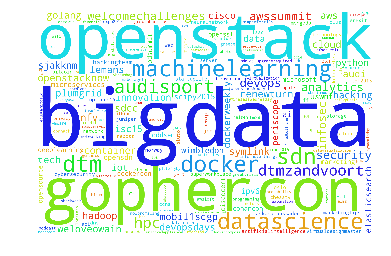

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=3000, height=2000).generate(word_str)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()